In [7]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

In [8]:
class Config:
    data_path = './datasets/serverless/cached/queue_id_{}.csv'.format(36)
    timestep = 12  # 时间步长，就是利用多少时间窗口
    batch_size = 32  # 批次大小
    feature_size = 7  # 每个步长对应的特征数量（跟数据集处理有关，我只保留了七个特征）
    hidden_size = 256  # 隐层大小
    out_channels = 50  # CNN输出通道
    num_heads = 1  # 注意力机制头的数量
    output_size = 1  # 由于是单输出任务，最终输出层大小为1，预测未来1天风速
    num_layers = 2  # lstm的层数
    epochs = 10  # 迭代轮数
    best_loss = 0.010  # 记录损失
    learning_rate = 0.0003  # 学习率
    model_name = 'cnn_lstm_attention'  # 模型名称
    save_path = './checkpoints/{}.pth'.format(model_name)  # 最优模型保存路径


config = Config()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("use {} train".format(device))

use cuda train


In [14]:
# 1.加载时间序列数据
df = pd.read_csv(config.data_path, index_col=0)

# 填充空值
# df = df.fillna(df.mean())
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

# 七个特征
print(df.head())

(3242, 7)
               CPU_USAGE  QUEUE_ID  CU  QUEUE_TYPE  MEM_USAGE  LJOB  RJOB
timestamp                                                                
1591268040000         32        36  16           0         17     0     0
1591268340000          3        36  16           0         18     0     0
1591268640000          5        36  16           0         18     0     0
1591268940000          2        36  16           0         18     0     0
1591269240000         15        36  16           0         19     0     0
<class 'pandas.core.frame.DataFrame'>
Index: 3242 entries, 1591268040000 to 1592265540000
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CPU_USAGE   3242 non-null   int64
 1   QUEUE_ID    3242 non-null   int64
 2   CU          3242 non-null   int64
 3   QUEUE_TYPE  3242 non-null   int64
 4   MEM_USAGE   3242 non-null   int64
 5   LJOB        3242 non-null   int64
 6   RJOB        3242 non-null   int64

In [15]:
# 2.将数据进行标准化
scaler = MinMaxScaler()
scaler_model = MinMaxScaler()
data: np.ndarray = scaler_model.fit_transform(np.array(df))
# only display
scaler.fit_transform(np.array(df['CPU_USAGE']).reshape(-1, 1))

array([[0.4025974 ],
       [0.02597403],
       [0.05194805],
       ...,
       [0.01298701],
       [0.01298701],
       [0.02597403]])

In [5]:
# 形成训练数据，例如12345789 12-3456789
def split_data(data: np.ndarray, timestep: int, feature_size: int):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep):
        # 第一列是CPU_USAGE
        dataX.append(data[index: index + timestep])
        dataY.append(data[index + timestep][0])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.8 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, feature_size)
    y_train = dataY[: train_size].reshape(-1, 1)

    x_test = dataX[train_size:, :].reshape(-1, timestep, feature_size)
    y_test = dataY[train_size:].reshape(-1, 1)

    return [x_train, y_train, x_test, y_test]


# 3.获取训练数据
# x_train: train_len,timestep,feature_size   y_train: train_len,output_size
# x_test: test_len,timestep,feature_size   y_test: test_len,output_size
x_train, y_train, x_test, y_test = split_data(data, config.timestep, config.feature_size)

In [6]:
# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           config.batch_size,
                                           False)

test_loader = torch.utils.data.DataLoader(test_data,
                                          config.batch_size,
                                          False)

In [7]:
from models.CNN_LSTM.CNN_LSTM_net import CNN_LSTM_Attention

model = CNN_LSTM_Attention(config.feature_size, config.timestep, config.hidden_size, config.num_layers,
                           config.out_channels, config.num_heads, config.output_size)
model = model.to(device)
loss_function = nn.MSELoss()  # 定义损失函数
loss_function = loss_function.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)  # 定义优化器

In [8]:
# 8.模型训练
for epoch in range(config.epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        # x_train: batch_size*timestep*feature_size  
        # y_train: batch_size*feature_size
        x_train, y_train = data  # 解包迭代器中的X和Y
        x_train: torch.Tensor = x_train.to(device)
        y_train: torch.Tensor = y_train.to(device)
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 config.epochs,
                                                                 loss)

    # 模型验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test.reshape(-1, 1))

    if test_loss <= config.best_loss:
        config.best_loss = test_loss
        print('best loss is {}, saving model'.format(config.best_loss))
        torch.save(model.state_dict(), config.save_path)

    gc.collect()
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()

print('Finished Training')

100%|██████████| 21/21 [00:00<00:00, 420.29it/s]


best loss is 0.00665506673976779, saving model


100%|██████████| 21/21 [00:00<00:00, 651.03it/s]


best loss is 0.005394618026912212, saving model


100%|██████████| 21/21 [00:00<00:00, 355.84it/s]


best loss is 0.00166325643658638, saving model


100%|██████████| 21/21 [00:00<00:00, 409.04it/s]


Finished Training


In [ ]:
state_dict = torch.load(config.save_path)
model.load_state_dict(state_dict)

In [ ]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print("==================")
print(x_test_tensor.shape)
print(y_test_tensor.shape)

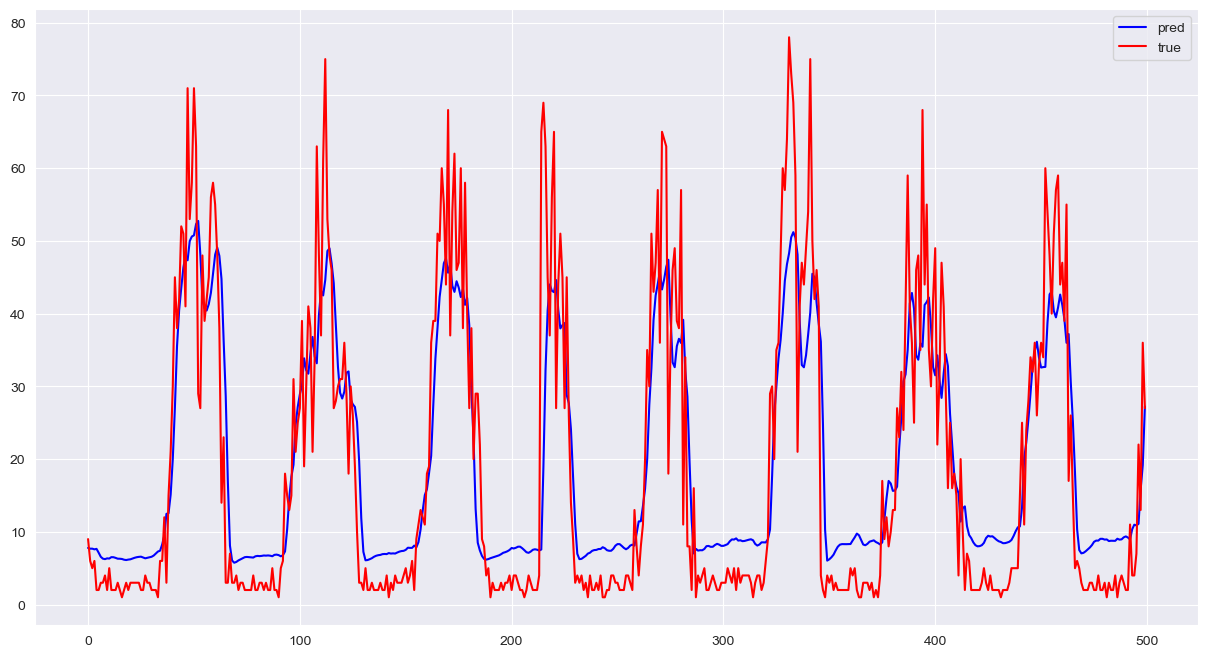

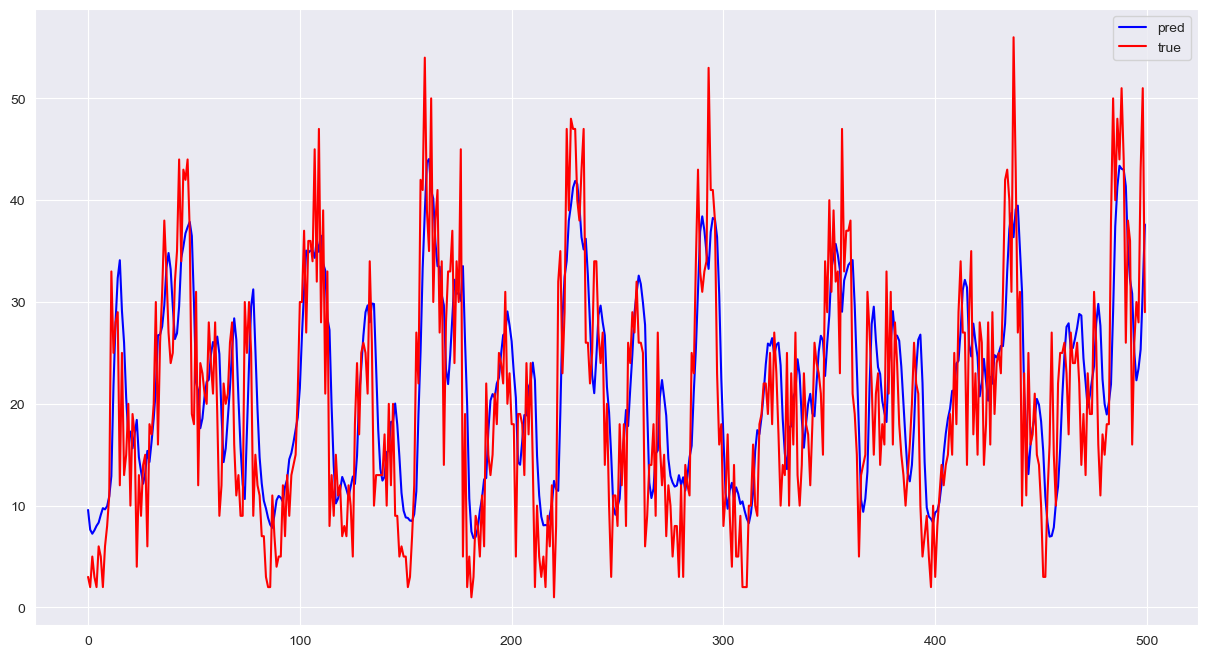

In [9]:
# 9.绘制结果
gc.collect()
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

# 显示多少时间步的数据，太多容易看不清
plot_size = 500
# 预测哪个时间范围的数据
train_pred_range = [0, 3000]
test_pred_range = [0, 600]

plt.figure(figsize=(15, 8))
plt.plot(
    scaler.inverse_transform(
        (model(x_train_tensor[train_pred_range[0]:train_pred_range[1]].to(device)).detach().cpu().numpy()[
         : plot_size]).reshape(-1,
                               1)),
    label='pred', color='blue')
plt.plot(
    scaler.inverse_transform(
        y_train_tensor[train_pred_range[0]:train_pred_range[1]].detach().numpy()[: plot_size].reshape(-1, 1)),
    label='true',
    color='red')
plt.legend()
plt.show()

y_test_pred = model(x_test_tensor[test_pred_range[0]:test_pred_range[1]].to(device))
plt.figure(figsize=(15, 8))
plt.plot(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()[: plot_size].reshape(-1, 1)), label='pred',
         color='blue')
plt.plot(
    scaler.inverse_transform(
        y_test_tensor[test_pred_range[0]:test_pred_range[1]].detach().numpy()[: plot_size].reshape(-1, 1)),
    label='true',
    color='red')
plt.legend()
plt.show()
